In [5]:
import os
import pypsa 
import matplotlib.pyplot as plt
plt.style.use("bmh")
import pandas as pd
import numpy as np
%matplotlib inline
import seaborn as sns  ###
import cartopy.crs as ccrs
sns.set(style='darkgrid') ### seaborn gives a nice design

In [6]:
cd /home/max/OneDrive/PHD-Flexibility/08_2_SecondPaper/unintended-storage-cycling/Model_script_github_only_h2_all_assets_no_hydro_solver_accuracy_base/scripts

/home/max/OneDrive/PHD-Flexibility/08_2_SecondPaper/unintended-storage-cycling/Model_script_github_only_h2_all_assets_no_hydro_solver_accuracy_base/scripts


In [7]:
from _helpers import *
from make_summary import assign_carriers
from plot_summary import plot_costs

## Upload network

In [8]:
##Upload ALL scnearios

#defines folder where the solved networks are (.nc files)
directory = r'/home/max/OneDrive/PHD-Flexibility/08_2_SecondPaper/unintended-storage-cycling/Model_script_github_only_h2_all_assets_no_hydro_solver_accuracy_base/results/networks/'
network_paths = []
#iterates through all the solved networks
for entry in os.scandir(directory):
    if entry.path.endswith(".nc") and entry.is_file():
        #create a list with all the file paths:
        network_paths.append(entry.path)
    
#Sort list
network_paths.sort()

print("\n".join(network_paths[0:]))


/home/max/OneDrive/PHD-Flexibility/08_2_SecondPaper/unintended-storage-cycling/Model_script_github_only_h2_all_assets_no_hydro_solver_accuracy_base/results/networks/elec_s_16_ec_lv1.25_Co2L-1H-charger+mc0.00000.nc
/home/max/OneDrive/PHD-Flexibility/08_2_SecondPaper/unintended-storage-cycling/Model_script_github_only_h2_all_assets_no_hydro_solver_accuracy_base/results/networks/elec_s_16_ec_lv1.25_Co2L-1H-charger+mc0.00001.nc
/home/max/OneDrive/PHD-Flexibility/08_2_SecondPaper/unintended-storage-cycling/Model_script_github_only_h2_all_assets_no_hydro_solver_accuracy_base/results/networks/elec_s_16_ec_lv1.25_Co2L-1H-charger+mc0.0001.nc
/home/max/OneDrive/PHD-Flexibility/08_2_SecondPaper/unintended-storage-cycling/Model_script_github_only_h2_all_assets_no_hydro_solver_accuracy_base/results/networks/elec_s_16_ec_lv1.25_Co2L-1H-charger+mc0.001.nc
/home/max/OneDrive/PHD-Flexibility/08_2_SecondPaper/unintended-storage-cycling/Model_script_github_only_h2_all_assets_no_hydro_solver_accuracy_base

In [9]:
#create a dictionary that contains networks abbr. ns
ns = {}

for i in range(0, len(network_paths)): ##full list
#for i in range(0, 2): ##just testing
    ns["n%s" %(i+10)] = pypsa.Network(network_paths[i])
    
ns

##NOTES. 
#mc_charger = n10-n19
#mc_dicharger = n20-n29
#mc_store = n30-n39
#mc_vre = n40-n49

/home/max/anaconda3/envs/pypsa-eur/lib/python3.8/site-packages/pypsa/io.py:769: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  pnl[attr] = pnl[attr].reindex(columns=df.index | columns, fill_value=default)
/home/max/anaconda3/envs/pypsa-eur/lib/python3.8/site-packages/pypsa/io.py:771: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  pnl[attr] = pnl[attr].reindex(columns=(pnl[attr].columns | columns))
INFO:pypsa.io:Imported network elec_s_16_ec_lv1.25_Co2L-1H-charger+mc0.00000.nc has buses, carriers, generators, global_constraints, lines, links, loads, stores
INFO:pypsa.io:Imported network elec_s_16_ec_lv1.25_Co2L-1H-charger+mc0.00001.nc has buses, carriers, generators, global_constraints, lines, links, loads, stores
INFO:pypsa.io:Imp

{'n10': Network ,
 'n11': Network ,
 'n12': Network ,
 'n13': Network ,
 'n14': Network ,
 'n15': Network ,
 'n16': Network ,
 'n17': Network ,
 'n18': Network ,
 'n19': Network ,
 'n20': Network ,
 'n21': Network ,
 'n22': Network ,
 'n23': Network ,
 'n24': Network ,
 'n25': Network ,
 'n26': Network ,
 'n27': Network ,
 'n28': Network ,
 'n29': Network ,
 'n30': Network ,
 'n31': Network ,
 'n32': Network ,
 'n33': Network ,
 'n34': Network ,
 'n35': Network ,
 'n36': Network ,
 'n37': Network ,
 'n38': Network ,
 'n39': Network ,
 'n40': Network ,
 'n41': Network ,
 'n42': Network ,
 'n43': Network ,
 'n44': Network ,
 'n45': Network ,
 'n46': Network ,
 'n47': Network ,
 'n48': Network ,
 'n49': Network }

In [10]:
list(ns.values())[0].generators_t.p.sum(axis=1)

name
2013-01-01 00:00:00     95955.571179
2013-01-01 01:00:00     93562.896165
2013-01-01 02:00:00     90834.064652
2013-01-01 03:00:00     90590.821566
2013-01-01 04:00:00     88341.734466
                           ...      
2013-12-31 19:00:00    102414.644819
2013-12-31 20:00:00    101539.806367
2013-12-31 21:00:00    101323.451960
2013-12-31 22:00:00    101881.854342
2013-12-31 23:00:00    100576.896476
Length: 8760, dtype: float64

In [11]:
#pd.DataFrame.from_dict(ns.keys())

In [12]:
#(len(network_paths)+10)

## Data preparation

### Amount of unintended cycling

The following steps are described below to detect unintended storage cycling:
1. Reading efficiencies
2. Create charging and discharging timeseries
3. Calculate amount of aggregated unintended storage cycling [MWh]
4. Summary outputs

#### 1. Reading efficiencies

In [13]:
cd '/home/max/OneDrive/PHD-Flexibility/08_2_SecondPaper/unintended-storage-cycling'

/home/max/OneDrive/PHD-Flexibility/08_2_SecondPaper/unintended-storage-cycling


In [14]:
costs = pd.read_csv("pypsa-eur-test1/data/costs.csv")
costs.head()

,technology,year,parameter,value,unit,source
0,solar-rooftop,2030,discount rate,0.04,per unit,standard for decentral
1,onwind,2030,lifetime,30.00,years,DEA https://ens.dk/en/our-services/projections...
2,offwind,2030,lifetime,30.00,years,DEA https://ens.dk/en/our-services/projections...
3,solar,2030,lifetime,25.00,years,IEA2010
4,solar-rooftop,2030,lifetime,25.00,years,IEA2010


In [15]:
##READING EFFICIENCY
costs = pd.read_csv("pypsa-eur-test1/data/costs.csv")
electrolysor_effi = costs.iloc[89]['value']
fuel_cell_effi = costs.iloc[93]['value']
battery_effi = costs.iloc[115]['value']

print(electrolysor_effi)
print(fuel_cell_effi)
print(battery_effi)

0.8
0.58
0.9


## 2. Functions. Create charging and Discharging Timeseries

Dataframe should look like:
USC(y-xis).sum for battery and H2 
MC(x-axis)

##Y-Axis MAYBE SMT LIKE BELOW:

Counting USC: print("USC/Discharge",(df['usc_h2'].mean()/df['p3_h2'].mean()))


##Generated indicators
Artificial FLH Discharger = (df['p3_h2']/df['p3_h2'].max()).mean()*8760) 
True FLH Discharger = ((df['p3_h2_corr']/df['p3_h2_corr'].max()).mean()*8760)             # not sure if corr. works
USC indicator as percentage over the year = (Artificial/True FLH)/8760 
USC indicator as percentage over the year = ((df['p0_b']-df['p0_b_corr'])/df['p0_b_corr'].max()).mean() 
USC indicator as timeseries = ((df['p0_h2']-df['p0_h2_corr'])/df['p0_h2_corr'].max())     # not sure if corr. works
USC curtailment =  usc_b[col][row] or  usc_h2[col][row] 


#Note that ['usc_h2'] includes charging and discharging artififical curtailment.
#example definition (p2_b[col][row] - p3_b[col][row]) + p2_b[col][row] / battery_effi

In [16]:
def create_p_df(n, name):
    
    ## CHARGING AND DISCHARGING TIMESERIES
        # p0 & p1 are related to charging
        # p2 & p3 are related to discharging
        # p0 * effi = p1

    ## Abbreviations
        #h2 = Hydrogen storage
        #b = battery storage

    ## REMOVES THE COLUMN INDEX (Code explanation)
        #.transpose().reset_index(drop = True, inplace = False).transpose()

    p0_h2 = abs(n.links_t.p0.filter(like='Electrolysis', axis='columns')).transpose().reset_index(drop = True, inplace = False).transpose()
    p1_h2 = abs(n.links_t.p1.filter(like='Electrolysis', axis='columns')).transpose().reset_index(drop = True, inplace = False).transpose()
    p2_h2 = abs(n.links_t.p0.filter(like='Fuel Cell', axis='columns')).transpose().reset_index(drop = True, inplace = False).transpose()
    p3_h2 = abs(n.links_t.p1.filter(like='Fuel Cell', axis='columns')).transpose().reset_index(drop = True, inplace = False).transpose()

#     p0_b = abs(n.links_t.p0.filter(like='battery charger', axis='columns')).transpose().reset_index(drop = True, inplace = False).transpose()
#     p1_b = abs(n.links_t.p1.filter(like='battery charger', axis='columns')).transpose().reset_index(drop = True, inplace = False).transpose()
#     p2_b = abs(n.links_t.p0.filter(like='battery discharger', axis='columns')).transpose().reset_index(drop = True, inplace = False).transpose()
#     p3_b = abs(n.links_t.p1.filter(like='battery discharger', axis='columns')).transpose().reset_index(drop = True, inplace = False).transpose()


    #Dataframes
    df = pd.DataFrame(data=(p0_h2.sum(axis=1)), columns=['p0_h2'])
    df['p1_h2'] = p1_h2.sum(axis=1)
    df['p2_h2'] = p2_h2.sum(axis=1)
    df['p3_h2'] = p3_h2.sum(axis=1)
#     df['p0_b'] = p0_b.sum(axis=1)
#     df['p1_b'] = p1_b.sum(axis=1)
#     df['p2_b'] = p2_b.sum(axis=1)
#     df['p3_b'] = p3_b.sum(axis=1)
    df['type'] = name
    return(df)

#### 3. Calculate amount of aggregated unintended storage cycling 

In [17]:

def add_pcorr_and_usc_2_df(n, name):

    ## CHARGING AND DISCHARGING TIMESERIES
        # p0 & p1 are related to charging
        # p2 & p3 are related to discharging
        # p0 * effi = p1

    ## Abbreviations
        #h2 = Hydrogen storage
        #b = battery storage

    ## REMOVES THE COLUMN INDEX (Code explanation)
        #.transpose().reset_index(drop = True, inplace = False).transpose()

    p0_h2 = abs(n.links_t.p0.filter(like='Electrolysis', axis='columns')).transpose().reset_index(drop = True, inplace = False).transpose()
    p1_h2 = abs(n.links_t.p1.filter(like='Electrolysis', axis='columns')).transpose().reset_index(drop = True, inplace = False).transpose()
    p2_h2 = abs(n.links_t.p0.filter(like='Fuel Cell', axis='columns')).transpose().reset_index(drop = True, inplace = False).transpose()
    p3_h2 = abs(n.links_t.p1.filter(like='Fuel Cell', axis='columns')).transpose().reset_index(drop = True, inplace = False).transpose()

#     p0_b = abs(n.links_t.p0.filter(like='battery charger', axis='columns')).transpose().reset_index(drop = True, inplace = False).transpose()
#     p1_b = abs(n.links_t.p1.filter(like='battery charger', axis='columns')).transpose().reset_index(drop = True, inplace = False).transpose()
#     p2_b = abs(n.links_t.p0.filter(like='battery discharger', axis='columns')).transpose().reset_index(drop = True, inplace = False).transpose()
#     p3_b = abs(n.links_t.p1.filter(like='battery discharger', axis='columns')).transpose().reset_index(drop = True, inplace = False).transpose()

    #Dataframes
    df = pd.DataFrame(data=(p0_h2.sum(axis=1)), columns=['p0_h2'])
    df['p1_h2'] = p1_h2.sum(axis=1)
    df['p2_h2'] = p2_h2.sum(axis=1)
    df['p3_h2'] = p3_h2.sum(axis=1)
#     df['p0_b'] = p0_b.sum(axis=1)
#     df['p1_b'] = p1_b.sum(axis=1)
#     df['p2_b'] = p2_b.sum(axis=1)
#     df['p3_b'] = p3_b.sum(axis=1)
    
    ## CHARGING AND DISCHARGING TIMESERIES
        # usc_h2 = timeseries of unintended storage cycling for hydrogen storage for all buses
        # usc_b = timeseries of unintended storage cycling for battery storage for all busses

    ## Abbreviations
        #h2 = Hydrogen storage
        #b = battery storage

    ## Number of required iterations
    i = p0_h2.shape[1] # number of columns
    j = p0_h2.shape[0] # number of rows

    ## Create empty dataframe

    usc_h2 = pd.DataFrame(np.zeros((j, i))) #Artificial curtailment from USC in H2
    usc_b = pd.DataFrame(np.zeros((j, i))) #Artificial curtailment from USC in Battery
    p0_h2_corr = pd.DataFrame(np.zeros((j, i)))
    p1_h2_corr = pd.DataFrame(np.zeros((j, i)))
    p2_h2_corr = pd.DataFrame(np.zeros((j, i)))
    p3_h2_corr = pd.DataFrame(np.zeros((j, i)))
#     p0_b_corr = pd.DataFrame(np.zeros((j, i)))
#     p1_b_corr = pd.DataFrame(np.zeros((j, i)))
#     p2_b_corr = pd.DataFrame(np.zeros((j, i)))
#     p3_b_corr = pd.DataFrame(np.zeros((j, i)))

    #Charge and discharge should never happen at the same time, as it is equal to dissipating energy. 
    #Dissipating energy in an energy storage is too expensive since it reduces the lifetime of these relative expensive devices.
    #There are cheaper ways to dissipate energy such as curtailing VRE or using electric coils.

    #Having charge and discharge at the same time is a signal USC exists.
    for col in range(i):
        for row in range(j):
            if p1_h2[col][row] > p2_h2[col][row]: #Charge cycle
                usc_h2[col][row] = (p2_h2[col][row] - p3_h2[col][row]) + p2_h2[col][row] / electrolysor_effi
                p0_h2_corr[col][row] = p0_h2[col][row] - p2_h2[col][row] / electrolysor_effi
                p1_h2_corr[col][row] = p1_h2[col][row] - p2_h2[col][row]
                p2_h2_corr[col][row] = 0
                p3_h2_corr[col][row] = 0
            elif p1_h2[col][row] == p2_h2[col][row] and p1_h2[col][row] > 0:
                p0_h2_corr[col][row] = 0
                p1_h2_corr[col][row] = 0               
                p2_h2_corr[col][row] = 0
                p3_h2_corr[col][row] = 0                
            else: #Discharge cycle
                usc_h2[col][row] = (p0_h2[col][row] - p1_h2[col][row]) + p1_h2[col][row]*(1 - fuel_cell_effi) 
                p3_h2_corr[col][row] = p3_h2[col][row] - p1_h2[col][row] * fuel_cell_effi
                p2_h2_corr[col][row] = p2_h2[col][row] - p1_h2[col][row]
                p1_h2_corr[col][row] = 0
                p0_h2_corr[col][row] = 0
    
    #corrected timeseries
    df['p0_h2_corr'] = p0_h2_corr.sum(axis=1).values
    df['p1_h2_corr'] = p1_h2_corr.sum(axis=1).values
    df['p2_h2_corr'] = p2_h2_corr.sum(axis=1).values
    df['p3_h2_corr'] = p3_h2_corr.sum(axis=1).values
#     df['p0_b_corr'] = p0_b_corr.sum(axis=1).values
#     df['p1_b_corr'] = p1_b_corr.sum(axis=1).values
#     df['p2_b_corr'] = p2_b_corr.sum(axis=1).values
#     df['p3_b_corr'] = p3_b_corr.sum(axis=1).values
    df['type'] = name+"corr"

    #USC curtailment (/Artificial curtailment). Shoulb be added to VRE curtailment or cheap dissipator
    df['usc_curtailment_h2_t'] = usc_h2.sum(axis=1).values
    #df['usc_curtailment_b_t'] = usc_b.sum(axis=1).values
    df['usc_indicator_p0_h2_t'] = ((df['p0_h2'].values-df['p0_h2_corr'])/df['p0_h2_corr'].max())
    df['usc_indicator_p3_h2_t'] = ((df['p3_h2'].values-df['p3_h2_corr'])/df['p3_h2_corr'].max())
    #df['usc_indicator_p0_b_t'] = ((df['p0_b'].values-df['p0_b_corr'])/df['p0_b_corr'].max())
    #df['usc_indicator_p3_b_t'] = ((df['p3_b'].values-df['p3_b_corr'])/df['p3_b_corr'].max())
    df_corr = df
    
    return(df_corr)

## With counter

In [18]:

def add_pcorr_and_usc_2_df(n, name):

    ## CHARGING AND DISCHARGING TIMESERIES
        # p0 & p1 are related to charging
        # p2 & p3 are related to discharging
        # p0 * effi = p1

    ## Abbreviations
        #h2 = Hydrogen storage
        #b = battery storage

    ## REMOVES THE COLUMN INDEX (Code explanation)
        #.transpose().reset_index(drop = True, inplace = False).transpose()

    p0_h2 = abs(n.links_t.p0.filter(like='Electrolysis', axis='columns')).transpose().reset_index(drop = True, inplace = False).transpose()
    p1_h2 = abs(n.links_t.p1.filter(like='Electrolysis', axis='columns')).transpose().reset_index(drop = True, inplace = False).transpose()
    p2_h2 = abs(n.links_t.p0.filter(like='Fuel Cell', axis='columns')).transpose().reset_index(drop = True, inplace = False).transpose()
    p3_h2 = abs(n.links_t.p1.filter(like='Fuel Cell', axis='columns')).transpose().reset_index(drop = True, inplace = False).transpose()

#     p0_b = abs(n.links_t.p0.filter(like='battery charger', axis='columns')).transpose().reset_index(drop = True, inplace = False).transpose()
#     p1_b = abs(n.links_t.p1.filter(like='battery charger', axis='columns')).transpose().reset_index(drop = True, inplace = False).transpose()
#     p2_b = abs(n.links_t.p0.filter(like='battery discharger', axis='columns')).transpose().reset_index(drop = True, inplace = False).transpose()
#     p3_b = abs(n.links_t.p1.filter(like='battery discharger', axis='columns')).transpose().reset_index(drop = True, inplace = False).transpose()
    
    #Dataframes
    df = pd.DataFrame(data=(p0_h2.sum(axis=1)), columns=['p0_h2'])
    df['p1_h2'] = p1_h2.sum(axis=1)
    df['p2_h2'] = p2_h2.sum(axis=1)
    df['p3_h2'] = p3_h2.sum(axis=1)
#     df['p0_b'] = p0_b.sum(axis=1)
#     df['p1_b'] = p1_b.sum(axis=1)
#     df['p2_b'] = p2_b.sum(axis=1)
#     df['p3_b'] = p3_b.sum(axis=1)
    
    ## CHARGING AND DISCHARGING TIMESERIES
        # usc_h2 = timeseries of unintended storage cycling for hydrogen storage for all buses
        # usc_b = timeseries of unintended storage cycling for battery storage for all busses

    ## Abbreviations
        #h2 = Hydrogen storage
        #b = battery storage

    ## Number of required iterations
    i = p0_h2.shape[1] # number of columns
    j = p0_h2.shape[0] # number of rows

    ## Create empty dataframe
    usc_count = pd.DataFrame(np.zeros((j, i)))
    usc_count_charge = pd.DataFrame(np.zeros((j, i)))
    usc_count_idle = pd.DataFrame(np.zeros((j, i)))
    usc_count_discharge = pd.DataFrame(np.zeros((j, i)))
    usc_count_total = pd.DataFrame(np.zeros((j, i)))
    usc_h2 = pd.DataFrame(np.zeros((j, i))) #Artificial curtailment from USC in H2
    usc_b = pd.DataFrame(np.zeros((j, i))) #Artificial curtailment from USC in Battery
    p0_h2_corr = pd.DataFrame(np.zeros((j, i)))
    p1_h2_corr = pd.DataFrame(np.zeros((j, i)))
    p2_h2_corr = pd.DataFrame(np.zeros((j, i)))
    p3_h2_corr = pd.DataFrame(np.zeros((j, i)))
#     p0_b_corr = pd.DataFrame(np.zeros((j, i)))
#     p1_b_corr = pd.DataFrame(np.zeros((j, i)))
#     p2_b_corr = pd.DataFrame(np.zeros((j, i)))
#     p3_b_corr = pd.DataFrame(np.zeros((j, i)))

    #Charge and discharge should never happen at the same time, as it is equal to dissipating energy. 
    #Dissipating energy in an energy storage is too expensive since it reduces the lifetime of these relative expensive devices.
    #There are cheaper ways to dissipate energy such as curtailing VRE or using electric coils.

    #threshold
    #if both discharge and charge is activated above the threshold USC = True
    x = 1
    
    
    #Having charge and discharge at the same time is a signal USC exists.
    for col in range(i):
        for row in range(j):
            if p1_h2.iloc[row,col] > p2_h2.iloc[row,col] and p1_h2.iloc[row,col] > x and p2_h2.iloc[row,col] > x: #Charge cycle
                usc_count_charge.iloc[row,col] = True
                usc_h2.iloc[row,col] = (p2_h2.iloc[row,col] - p3_h2.iloc[row,col]) + p2_h2.iloc[row,col] / electrolysor_effi
                p0_h2_corr.iloc[row,col] = p0_h2.iloc[row,col] - p2_h2.iloc[row,col] / electrolysor_effi
                p1_h2_corr.iloc[row,col] = p1_h2.iloc[row,col] - p2_h2.iloc[row,col]
                p2_h2_corr.iloc[row,col] = 0
                p3_h2_corr.iloc[row,col] = 0
            elif p1_h2.iloc[row,col] == p2_h2.iloc[row,col] and p1_h2.iloc[row,col] > x: #Idle cycle
                usc_count_idle.iloc[row,col] = True
                p0_h2_corr.iloc[row,col] = 0
                p1_h2_corr.iloc[row,col] = 0               
                p2_h2_corr.iloc[row,col] = 0
                p3_h2_corr.iloc[row,col] = 0                
            elif p1_h2.iloc[row,col] < p2_h2.iloc[row,col] and p1_h2.iloc[row,col] > x and p2_h2.iloc[row,col] > x: #Discharge cycle
                usc_count_discharge.iloc[row,col] = True
                usc_h2.iloc[row,col] = (p0_h2.iloc[row,col] - p1_h2.iloc[row,col]) + p1_h2.iloc[row,col]*(1 - fuel_cell_effi) 
                p3_h2_corr.iloc[row,col] = p3_h2.iloc[row,col] - p1_h2.iloc[row,col] * fuel_cell_effi
                p2_h2_corr.iloc[row,col] = p2_h2.iloc[row,col] - p1_h2.iloc[row,col]
                p1_h2_corr.iloc[row,col] = 0
                p0_h2_corr.iloc[row,col] = 0
            else: 
                usc_count.iloc[row,col] = False
                
    
    
#     usc_count_charge = (usc_count_charge.sum().sum())/p0_h2.shape[1] #average time steps for which USC = True
#     usc_count_idle = (usc_count_idle.sum().sum())/p0_h2.shape[1] #average time steps for which USC = True
#     usc_count_discharge = (usc_count_discharge.sum().sum())/p0_h2.shape[1] #average time steps for which USC = True
    usc_count_charge = usc_count_charge.sum(axis=1).values #average time steps for which USC = True
    usc_count_idle = usc_count_idle.sum(axis=1).values #average time steps for which USC = True
    usc_count_discharge = usc_count_discharge.sum(axis=1).values #average time steps for which USC = True    
    usc_total = usc_count_charge + usc_count_idle + usc_count_discharge
    
    #add counter to df
    ####
    df['usc_count_charge'] = usc_count_charge
    df['usc_count_idle'] = usc_count_idle
    df['usc_count_discharge'] = usc_count_discharge
    df['usc_total'] = usc_total
    ####
    
    
    #corrected timeseries
    df['p0_h2_corr'] = p0_h2_corr.sum(axis=1).values
    df['p1_h2_corr'] = p1_h2_corr.sum(axis=1).values
    df['p2_h2_corr'] = p2_h2_corr.sum(axis=1).values
    df['p3_h2_corr'] = p3_h2_corr.sum(axis=1).values
#     df['p0_b_corr'] = p0_b_corr.sum(axis=1).values
#     df['p1_b_corr'] = p1_b_corr.sum(axis=1).values
#     df['p2_b_corr'] = p2_b_corr.sum(axis=1).values
#     df['p3_b_corr'] = p3_b_corr.sum(axis=1).values
    df['type'] = name+"corr"

    #USC curtailment (/Artificial curtailment). Shoulb be added to VRE curtailment or cheap dissipator
    df['usc_curtailment_h2_t'] = usc_h2.sum(axis=1).values
    #df['usc_curtailment_b_t'] = usc_b.sum(axis=1).values
    df['usc_indicator_p0_h2_t'] = ((df['p0_h2'].values-df['p0_h2_corr'])/df['p0_h2_corr'].max())
    df['usc_indicator_p3_h2_t'] = ((df['p3_h2'].values-df['p3_h2_corr'])/df['p3_h2_corr'].max())
    #df['usc_indicator_p0_b_t'] = ((df['p0_b'].values-df['p0_b_corr'])/df['p0_b_corr'].max())
    #df['usc_indicator_p3_b_t'] = ((df['p3_b'].values-df['p3_b_corr'])/df['p3_b_corr'].max())
    df['case'] = 'accuracy_base'
    df_corr = df
    
    
    return(df_corr)

In [19]:
def calculate_FLH(df, storage, name, **kwargs):
    if storage == "discharger":
        artificial_FLH_H2_discharger = (df['p3_h2']/df['p3_h2'].max()).mean()*8760
        true_FLH_H2_discharger = (df['p3_h2_corr']/df['p3_h2_corr'].max()).mean()*8760
        difference_FLH_H2_discharger = artificial_FLH_H2_discharger - true_FLH_H2_discharger
        usc_count_charge = df['usc_count_charge'].sum()/16
        usc_count_idle = df['usc_count_idle'].sum()/16
        usc_count_discharge = df['usc_count_discharge'].sum()/16
        usc_count_total = df['usc_total'].sum()/16
        return(name, artificial_FLH_H2_discharger, true_FLH_H2_discharger, difference_FLH_H2_discharger,usc_count_charge,usc_count_idle,usc_count_discharge,usc_count_total)
    
    if storage == "electrolysor":
        artificial_FLH_h2_charger = ((df['p0_h2']/df['p0_h2'].max()).mean()*8760)
        true_FLH_h2_charger = (df['p0_h2_corr']/df['p0_h2_corr'].max()).mean()*8760
        difference_FLH_h2_charger = artificial_FLH_h2_charger - true_FLH_h2_charger
        return(name, artificial_FLH_h2_charger, true_FLH_h2_charger, difference_FLH_h2_charger)
    
    if storage == "all_assets":
        kwargs = 1
    
    else:
        print("choose for <storage> between 'h2' or 'battery' in calculate_FLH(df, storage)")

In [20]:
def calculate_objective(n, name):
    objective = n.objective/(10**9)
    return(name, objective)

## Prepare Data for Artificial FLH plot

In [21]:
values = list(ns.values())
keys = list(ns.keys())
FLH_h2_discharger =  []
FLH_b =  []
FLH_h2_charger = []
df = []

for i in range(0, len(keys)):
     A = add_pcorr_and_usc_2_df(values[i], keys[i])
     B = calculate_FLH(A, "discharger", keys[i])
     C = calculate_FLH(A, "electrolysor", keys[i])
     #D = calculate_FLH(A, "all_assets", keys[i], values[i])
     df.append(A)
     FLH_h2_discharger.append(B)
     FLH_h2_charger.append(C)

INFO:numexpr.utils:NumExpr defaulting to 8 threads.


In [22]:
#FLH_h2_charger

In [23]:
#FLH_h2_discharger

In [24]:
#df[0].usc_count_charge.sum()

In [25]:
# #generators
# genenerator_dispatch = n.generators_t.p.sum().groupby(n.generators.carrier).sum()
# genenerator_dispatch_capacity = n.generators.p_nom_opt.groupby(n.generators.carrier).sum()

# #H2 - Already integrated
# # storage_dispatch = n.stores_t.p[(n.stores_t.p[n.stores_t.p.columns] <= 0)].sum().groupby(n.stores.carrier).sum()
# # storage_store = n.stores_t.p[(n.stores_t.p[n.stores_t.p.columns] >= 0)].sum().groupby(n.stores.carrier).sum()

# #hydro_PHS
# storage_unit_dispatch = n.storage_units_t.p_dispatch.sum().groupby(n.storage_units.carrier).sum()
# storage_unit_store = n.storage_units_t.p_store.sum().groupby(n.storage_units.carrier).sum()
# storage_unit_capacity = n.storage_units.p_nom.groupby(n.storage_units.carrier).sum()

# #FLH 
# FLH_storage_unit = storage_unit_dispatch/storage_unit_capacity
# FLH_generator = genenerator_dispatch/genenerator_dispatch_capacity

# #FLH_generator['ror']

# SOS

In [72]:
df_FLH_h2_discharger = pd.DataFrame(
    FLH_h2_discharger, 
    columns = ['Network','Artificial FLH','Corrected FLH','Difference FLH','usc_count_charge','usc_count_idle','usc_count_discharge','usc_count_total'])

df_FLH_h2_discharger['scenario'] = [
    #charger
    0, 
    10**-5,
    10**-4,
    10**-3,
    10**-2,
    10**-1,
    10**0,
    10**1,
    10**2,
    10**3,
    
    #discharger
    0, 
    10**-5,
    10**-4,
    10**-3,
    10**-2,
    10**-1,
    10**0,
    10**1,
    10**2,
    10**3,
    
    #store
    0, 
    10**-5,
    10**-4,
    10**-3,
    10**-2,
    10**-1,
    10**0,
    10**1,
    10**2,
    10**3,
    
    #vre
    0, 
    10**-5,
    10**-4,
    10**-3,
    10**-2,
    10**-1,
    10**0,
    10**1,
    10**2,
    10**3,
    ]
#if difference is close to 0, indicate true FLH

#print(df_FLH_h2_discharger)

In [73]:
df_FLH_h2_charger = pd.DataFrame(
    FLH_h2_charger, 
    columns = ['Network','Artificial FLH','Corrected FLH','Difference FLH'])

df_FLH_h2_charger['scenario'] = [
    #charger
    0, 
    10**-5,
    10**-4,
    10**-3,
    10**-2,
    10**-1,
    10**0,
    10**1,
    10**2,
    10**3,
    
    #discharger
    0, 
    10**-5,
    10**-4,
    10**-3,
    10**-2,
    10**-1,
    10**0,
    10**1,
    10**2,
    10**3,
    
    #store
    0, 
    10**-5,
    10**-4,
    10**-3,
    10**-2,
    10**-1,
    10**0,
    10**1,
    10**2,
    10**3,
    
    #vre
    0, 
    10**-5,
    10**-4,
    10**-3,
    10**-2,
    10**-1,
    10**0,
    10**1,
    10**2,
    10**3,
    ]
#if difference is close to 0, indicate true FLH

#print(df_FLH_h2_discharger)

In [74]:
FLH_h2_discharger = df_FLH_h2_discharger.drop('Network',axis=1).set_index("scenario") #.index_column("scenario")

In [75]:
FLH_h2_charger = df_FLH_h2_charger.drop('Network',axis=1).set_index("scenario") #.index_column("scenario")

## Prepare Dataframe for MC-plot

In [76]:
cd "/home/max/OneDrive/PHD-Flexibility/08_2_SecondPaper/unintended-storage-cycling/Model_scripts"

/home/max/OneDrive/PHD-Flexibility/08_2_SecondPaper/unintended-storage-cycling/Model_scripts


In [77]:
import sys, os
import yaml

with open("config.yaml", 'r') as stream:
    config = yaml.safe_load(stream)

In [78]:
#def aggregate_costs(n, flatten=False, opts=None, existing_only=False):
for key, n in ns.items():
    assign_carriers(n)
    
costs = pd.DataFrame({k: aggregate_costs(n) for k, n in ns.items()}).sort_index(axis=1)#.drop("load")
costs = costs.rename(index=config["plotting"]["nice_names"])
costs = costs/10**9 #Conversion to billions
#costs[:]

In [79]:
costs = costs.rename(index={
    'H2 electrolysis': 'Hydrogen Storage',
    'H2 storage': 'Hydrogen Storage',
    'H2 fuel cell': 'Hydrogen Storage',
    'hydro+PHS': 'Reservoir & Dam & Pump Hydro'
                            })
costs = costs.groupby(["carrier"]).sum()
costs = costs.reindex([
    "Hydrogen Storage",
    "Reservoir & Dam & Pump Hydro",
    "Run of River",
    "Offshore Wind (AC)",
    "Offshore Wind (DC)",
    "Onshore Wind",
    "Solar",
    "Transmission Lines"
])
#costs['colors']
#costs

In [80]:
costs = costs.drop(['Run of River', 'Reservoir & Dam & Pump Hydro'])

In [81]:
costs= costs.rename(columns={
    #charger
    "n10": 0, 
    "n11": 10**-5,
    "n12": 10**-4,
    "n13": 10**-3,
    "n14": 10**-2,
    "n15": 10**-1,
    "n16": 10**0,
    "n17": 10**1,
    "n18": 10**2,
    "n19": 10**3,
    
    #discharger
    "n20": 0, 
    "n21": 10**-5,
    "n22": 10**-4,
    "n23": 10**-3,
    "n24": 10**-2,
    "n25": 10**-1,
    "n26": 10**0,
    "n27": 10**1,
    "n28": 10**2,
    "n29": 10**3,
    
    #store
    "n30": 0, 
    "n31": 10**-5,
    "n32": 10**-4,
    "n33": 10**-3,
    "n34": 10**-2,
    "n35": 10**-1,
    "n36": 10**0,
    "n37": 10**1,
    "n38": 10**2,
    "n39": 10**3,
    
    #vre
    "n40": 0, 
    "n41": 10**-5,
    "n42": 10**-4,
    "n43": 10**-3,
    "n44": 10**-2,
    "n45": 10**-1,
    "n46": 10**0,
    "n47": 10**1,
    "n48": 10**2,
    "n49": 10**3,
})

## Plot FLH _H2

In [82]:
#mc_charger = n10-n19
#mc_dicharger = n20-n29
#mc_store = n30-n39
#mc_vre = n40-n49

In [83]:
FLH_h2_discharger

,Artificial FLH,Corrected FLH,Difference FLH,usc_count_charge,usc_count_idle,usc_count_discharge,usc_count_total
scenario,,,,,,,
0.00000,1612.705314,736.556201,876.149113,3824.2500,0.0,1356.8125,5181.0625
0.00001,1618.767661,738.069388,880.698272,3806.9375,0.0,1374.3125,5181.2500
0.00010,1617.135107,738.218533,878.916574,3783.0625,0.0,1398.0625,5181.1250
0.00100,1517.259118,700.738323,816.520795,3840.2500,0.0,1340.8125,5181.0625
0.01000,1393.643822,622.959225,770.684598,3758.2500,0.0,1422.9375,5181.1875
0.10000,1293.094831,558.575879,734.518952,3483.5625,0.0,1697.5000,5181.0625
1.00000,1264.079364,NaN,NaN,0.0000,0.0,0.0000,0.0000
10.00000,1244.892851,NaN,NaN,0.0000,0.0,0.0000,0.0000
100.00000,1107.296394,NaN,NaN,0.0000,0.0,0.0000,0.0000


In [84]:
FLH_h2_discharger1 = FLH_h2_discharger.drop(columns = ["Corrected FLH", 'Difference FLH'])
FLH_h2_discharger1.rename(columns = {'Artificial FLH':'MC charger'}, inplace=True)
FLH_h2_discharger1['MC discharger'] = FLH_h2_discharger.iloc[10:20,0]
FLH_h2_discharger1['MC store'] = FLH_h2_discharger.iloc[20:30,0]
FLH_h2_discharger1['MC renewables'] = FLH_h2_discharger.iloc[30:40,0]
FLH_h2_discharger1['scenario'] = 'base1'

In [85]:
FLH_h2_discharger1.head()

,MC charger,usc_count_charge,usc_count_idle,usc_count_discharge,usc_count_total,MC discharger,MC store,MC renewables,scenario
scenario,,,,,,,,,
0.00000,1612.705314,3824.2500,0.0,1356.8125,5181.0625,1602.339117,1614.058698,1612.705314,base1
0.00001,1618.767661,3806.9375,0.0,1374.3125,5181.2500,1621.219884,1617.764445,1611.492710,base1
0.00010,1617.135107,3783.0625,0.0,1398.0625,5181.1250,1591.244698,1577.868790,1589.831718,base1
0.00100,1517.259118,3840.2500,0.0,1340.8125,5181.0625,1547.265750,1454.551300,1540.950018,base1
0.01000,1393.643822,3758.2500,0.0,1422.9375,5181.1875,1424.127682,1349.755759,1397.137191,base1


In [86]:
#FLH_h2_discharger1.to_csv('/home/max/OneDrive/PHD-Flexibility/08_2_SecondPaper/unintended-storage-cycling/scenario_base1.csv')

Text(0, 0.5, 'Discharger Full Load Hours [h]')

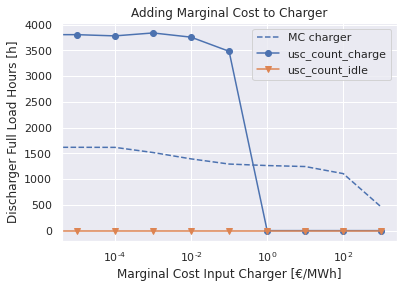

In [87]:
lines = FLH_h2_discharger1.iloc[0:10,0:3].plot(style=["--",'bo-',"v-","x-"])
plt.xscale("log")
plt.title("Adding Marginal Cost to Charger")
plt.xlabel("Marginal Cost Input Charger [€/MWh]")
plt.ylabel("Discharger Full Load Hours [h]") #(full usage/year)

Text(0, 0.5, 'Discharger Full Load Hours [h]')

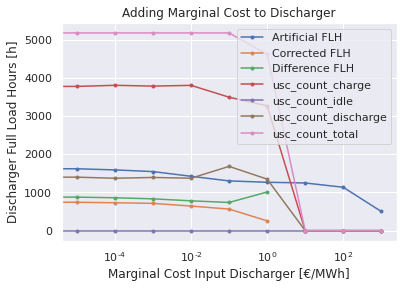

In [88]:
lines = FLH_h2_discharger.iloc[10:20,:].plot(style='.-')
plt.xscale("log")
plt.title("Adding Marginal Cost to Discharger")
plt.xlabel("Marginal Cost Input Discharger [€/MWh]")
plt.ylabel("Discharger Full Load Hours [h]") #(full usage/year)

Text(0, 0.5, 'Discharger Full Load Hours [h]')

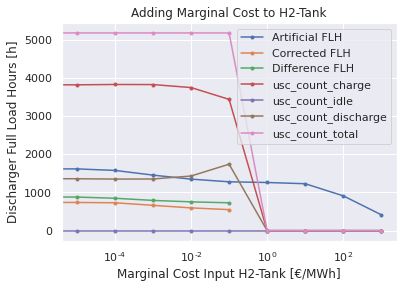

In [89]:
lines = FLH_h2_discharger.iloc[20:30,:].plot(style='.-')
plt.xscale("log")
plt.title("Adding Marginal Cost to H2-Tank")
plt.xlabel("Marginal Cost Input H2-Tank [€/MWh]")
plt.ylabel("Discharger Full Load Hours [h]") #(full usage/year)

Text(0, 0.5, 'Discharger Full Load Hours [h]')

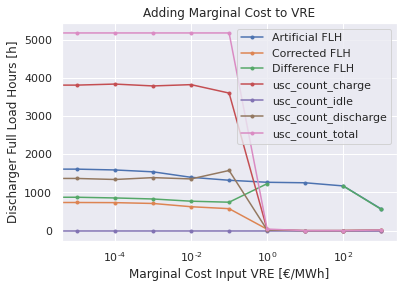

In [90]:
lines = FLH_h2_discharger.iloc[30:40,:].plot(style='.-')
plt.xscale("log")
plt.title("Adding Marginal Cost to VRE")
plt.xlabel("Marginal Cost Input VRE [€/MWh]")
plt.ylabel("Discharger Full Load Hours [h]") #(full usage/year)

In [91]:
FLH_h2_discharger.iloc[0:10,:]
FLH_h2_discharger.iloc[10:20,:]
FLH_h2_discharger.iloc[20:30,:]
FLH_h2_discharger.iloc[30:40,:]

,Artificial FLH,Corrected FLH,Difference FLH,usc_count_charge,usc_count_idle,usc_count_discharge,usc_count_total
scenario,,,,,,,
0.00000,1612.705314,736.556201,876.149113,3824.2500,0.0,1356.8125,5181.0625
0.00001,1611.492710,736.977769,874.514941,3813.6875,0.0,1367.3750,5181.0625
0.00010,1589.831718,733.495588,856.336129,3841.0000,0.0,1340.0625,5181.0625
0.00100,1540.950018,711.620503,829.329516,3792.0625,0.0,1389.0625,5181.1250
0.01000,1397.137191,626.247215,770.889976,3826.1875,0.0,1354.8750,5181.0625
0.10000,1320.031827,575.369805,744.662022,3605.1250,0.0,1575.9375,5181.0625
1.00000,1266.750948,36.638073,1230.112875,23.6875,0.0,16.6250,40.3125
10.00000,1253.924310,NaN,NaN,0.0000,0.0,0.0000,0.0000
100.00000,1171.175330,1.176714,1169.998616,0.1875,0.0,0.2500,0.4375


## Plot Total System Cost 

In [92]:
##NOTES. 
#mc_discharger = n10-n19
#mc_ratio = n20-n29
#mc_vre = n30-n39

In [93]:
color = (#"#b8ea04", 
"#ea048a", 
#'#08ad97', 
#"#4adbc8", 
"#6895dd", 
"#74c6f2", 
"#235ebc", 
"#f9d002", 
"#70af1d")

#battery,
#hydrogen storage
#reservoir & co
#run of river
#offshore AC
#offshore DC
#onshore
#solar
#transmission

In [98]:
costs

,0.00000,0.00001,0.00010,0.00100,0.01000,0.10000,1.00000,10.00000,100.00000,1000.00000,...,0.00000,0.00001,0.00010,0.00100,0.01000,0.10000,1.00000,10.00000,100.00000,1000.00000
carrier,,,,,,,,,,,,,,,,,,,,,
Hydrogen Storage,17.551390,17.551740,17.551731,17.551376,17.553611,17.566878,17.715213,19.107512,31.216276,67.819000,...,17.551390,17.551708,17.551110,17.551662,17.551150,17.550490,17.537728,17.410660,16.063281,10.217771
Offshore Wind (AC),3.360500,3.360626,3.360597,3.360112,3.360219,3.359947,3.358785,3.360156,3.413709,4.588328,...,3.360500,3.361126,3.359553,3.360078,3.360284,3.366916,3.418620,3.942649,9.054627,47.849666
Offshore Wind (DC),11.872635,11.870434,11.875505,11.872586,11.878847,11.883723,11.897523,12.305791,13.224770,16.538452,...,11.872635,11.871102,11.882333,11.882983,11.886761,11.899951,12.110909,14.236048,34.527231,136.458428
Onshore Wind,12.761439,12.763286,12.758964,12.761373,12.754381,12.755101,12.763204,12.715996,15.932388,46.156609,...,12.761439,12.763229,12.751050,12.750619,12.751087,12.779979,12.972425,14.915507,36.120171,299.251076
Solar,8.693384,8.693529,8.693297,8.693564,8.694011,8.692682,8.691506,8.619801,7.883737,15.193228,...,8.693384,8.693028,8.694204,8.694248,8.695384,8.703859,8.808296,9.830722,19.067617,134.848417
Transmission Lines,1.926031,1.926023,1.926074,1.926003,1.926010,1.926001,1.925925,1.926043,1.926109,1.925967,...,1.926031,1.926077,1.925971,1.925989,1.925978,1.926050,1.925927,1.925934,1.926241,1.926705


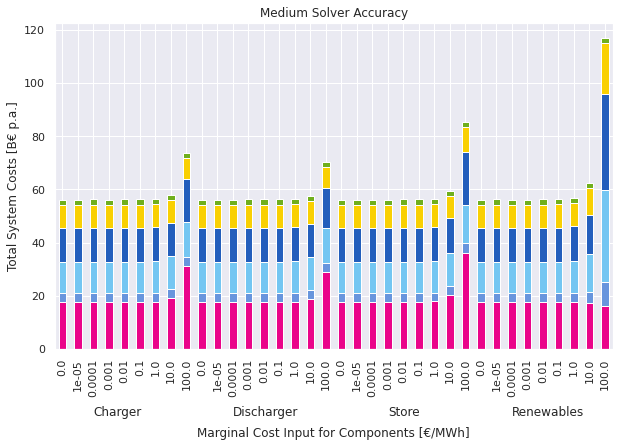

In [97]:
costs.iloc[:,:].T.drop([1000.0]).plot.bar(stacked=True, figsize=(10,6), color = color, legend=None)
#plt.legend(loc='upper left', frameon=True, title="")
#plt.legend(loc=(1.04,0))
plt.title("Medium Solver Accuracy")
plt.xlabel("Marginal Cost Input for Components [€/MWh]", labelpad=30)
plt.ylabel("Total System Costs [B€ p.a.]")
plt.text(2,-25, 'Charger')
plt.text(11,-25, 'Discharger')
plt.text(21,-25, 'Store')
plt.text(29,-25, 'Renewables')

plt.savefig('medium_accuracy_total_system_cost.pdf', bbox_inches='tight')
#(y-axis - TOTAL SYSTEM COSTS [GW]) | x-axis - MC-base etc)... add MC base text field & color according to the scenario green,blue,red"

In [99]:
color = (
"#b8ea04", 
"#ea048a",
#'#08ad97', 
#"#4adbc8", 
"#6895dd", 
"#74c6f2", 
"#235ebc", 
"#f9d002" 
#"#70af1d"
)


#reservoir & co
#run of river
#offshore AC
#offshore DC
#onshore
#solar
#transmission
#battery,
#hydrogen storage

In [100]:
def aggregate_p_nom(n):
    return pd.concat([
        n.generators.groupby("carrier").p_nom_opt.sum(),
        n.storage_units.groupby("carrier").p_nom_opt.sum(),
        n.links.groupby("carrier").p_nom_opt.sum(),
        n.loads_t.p.groupby(n.loads.carrier,axis=1).sum().mean()
    ])

In [101]:
#def aggregate_costs(n, flatten=False, opts=None, existing_only=False):
for key, n in ns.items():
    assign_carriers(n)
    
costs = pd.DataFrame({k: aggregate_p_nom(n) for k, n in ns.items()}).sort_index(axis=1)#.drop("load")
#colors = costs.index.map(config["plotting"]["tech_colors"])
#colors = (config["plotting"]["tech_colors"])
costs = costs.rename(index=config["plotting"]["nice_names"])

costs = costs/1000 #Conversion to billions
#costs[:]
costs = costs.drop(["electricity", 
                    #"H2 electrolysis",
                    #"H2 fuel cell", 
                    "Transmission Lines"
                   ])
costs = costs.rename(columns={
    #charger
    "n10": 0, 
    "n11": 10**-5,
    "n12": 10**-4,
    "n13": 10**-3,
    "n14": 10**-2,
    "n15": 10**-1,
    "n16": 10**0,
    "n17": 10**1,
    "n18": 10**2,
    "n19": 10**3,
    
    #discharger
    "n20": 0, 
    "n21": 10**-5,
    "n22": 10**-4,
    "n23": 10**-3,
    "n24": 10**-2,
    "n25": 10**-1,
    "n26": 10**0,
    "n27": 10**1,
    "n28": 10**2,
    "n29": 10**3,
    
    #store
    "n30": 0, 
    "n31": 10**-5,
    "n32": 10**-4,
    "n33": 10**-3,
    "n34": 10**-2,
    "n35": 10**-1,
    "n36": 10**0,
    "n37": 10**1,
    "n38": 10**2,
    "n39": 10**3,
    
    #vre
    "n40": 0, 
    "n41": 10**-5,
    "n42": 10**-4,
    "n43": 10**-3,
    "n44": 10**-2,
    "n45": 10**-1,
    "n46": 10**0,
    "n47": 10**1,
    "n48": 10**2,
    "n49": 10**3,
})



In [102]:
costs = costs.reindex([
    "H2 electrolysis",
    "H2 fuel cell",
    "Offshore Wind (AC)",
    "Offshore Wind (DC)",
    "Onshore Wind",
    "Solar",
])

In [103]:
costs

,0.00000,0.00001,0.00010,0.00100,0.01000,0.10000,1.00000,10.00000,100.00000,1000.00000,...,0.00000,0.00001,0.00010,0.00100,0.01000,0.10000,1.00000,10.00000,100.00000,1000.00000
carrier,,,,,,,,,,,,,,,,,,,,,
H2 electrolysis,74.220421,74.221677,74.221070,74.217921,74.214077,74.176028,73.977983,71.355258,54.437552,37.405929,...,74.220421,74.223397,74.203895,74.208488,74.200301,74.209554,74.084571,72.818317,61.603947,47.325151
H2 fuel cell,119.259695,119.257542,119.257721,119.259952,119.256891,119.254404,119.229373,119.069864,116.408612,102.973885,...,119.259695,119.257348,119.256320,119.254290,119.253261,119.257157,119.249951,119.162884,118.130949,109.074959
Offshore Wind (AC),16.432703,16.433326,16.433178,16.430781,16.431308,16.429962,16.424204,16.430995,16.696825,22.509591,...,16.432703,16.435801,16.427975,16.430302,16.428651,16.434497,16.424322,16.425182,16.448364,21.961145
Offshore Wind (DC),48.411959,48.403117,48.423461,48.411725,48.436835,48.456378,48.511721,50.148306,53.832121,67.115330,...,48.411959,48.405804,48.450724,48.452544,48.460084,48.437421,48.532764,49.416951,52.912428,67.113153
Onshore Wind,116.760806,116.777712,116.738163,116.760202,116.696229,116.702817,116.776959,116.345027,145.773414,422.309971,...,116.760806,116.777164,116.665541,116.659664,116.645010,116.722037,116.622798,116.089764,127.767838,310.069968
Solar,157.877616,157.880248,157.876024,157.880886,157.888997,157.864860,157.843511,156.541287,143.173890,275.919076,...,157.877616,157.871128,157.892290,157.891139,157.892448,157.855734,157.851427,157.303838,150.020183,247.768755


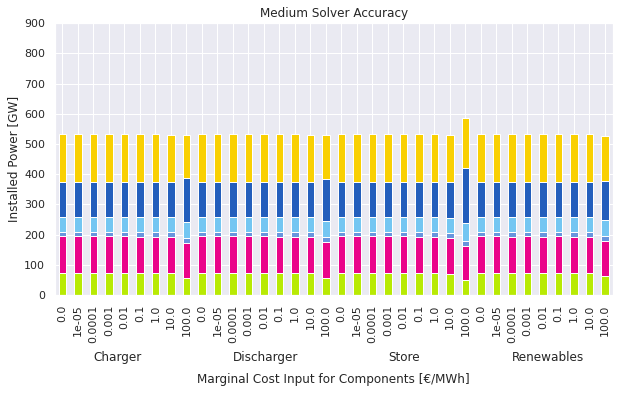

In [106]:
#costs.T.plot.bar(stacked=True, figsize=(10,10),color = color)
costs.T.drop([1000.0]).rename(columns={"H2 fuel cell" : "Hydrogen fuel cell", "H2 electrolysis" : "Hydrogen electrolyser"}).plot.bar(stacked=True, figsize=(10,5),color = color, legend = "")
plt.ylim((0,900))
#plt.legend(loc='upper left', frameon=True, title="")
plt.title("Medium Solver Accuracy")
plt.xlabel("Marginal Cost Input for Components [€/MWh]", labelpad=30)
plt.ylabel("Installed Power [GW]")
plt.text(2,-220, 'Charger')
plt.text(11,-220, 'Discharger')
plt.text(21,-220, 'Store')
plt.text(29,-220, 'Renewables')

plt.savefig('medium_accuracy_installed_power.pdf', bbox_inches='tight')

Text(0, 0.5, 'Total System Costs [B€ p.a.]')

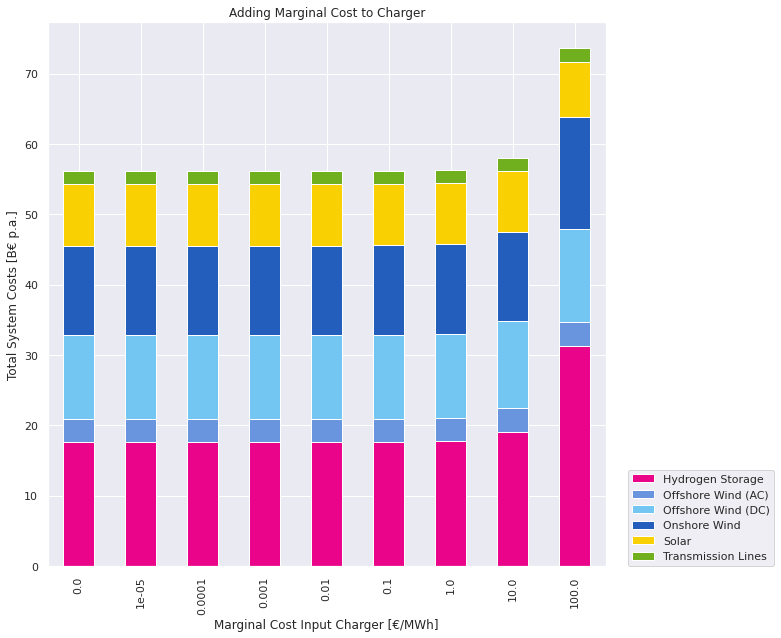

In [48]:
costs.iloc[:,0:9].T.plot.bar(stacked=True, figsize=(10,10), color = color)
plt.legend(loc=(1.04,0))
plt.title("Adding Marginal Cost to Charger")
plt.xlabel("Marginal Cost Input Charger [€/MWh]")
plt.ylabel("Total System Costs [B€ p.a.]")


Text(0, 0.5, 'Total System Costs [B€ p.a.]')

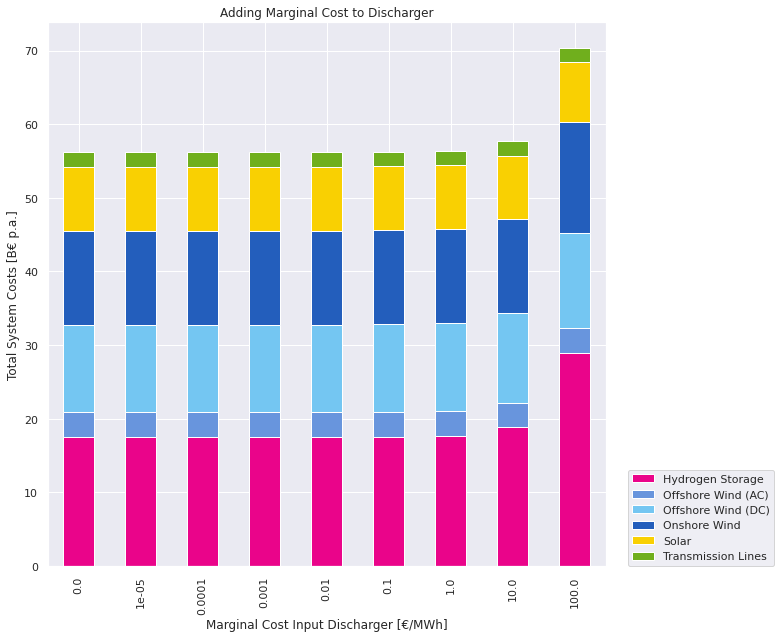

In [49]:
costs.iloc[:,10:19].T.plot.bar(stacked=True, figsize=(10,10),color = color)
plt.legend(loc=(1.04,0))
plt.title("Adding Marginal Cost to Discharger")
plt.xlabel("Marginal Cost Input Discharger [€/MWh]")
plt.ylabel("Total System Costs [B€ p.a.]")

Text(0, 0.5, 'Total System Costs [B€ p.a.]')

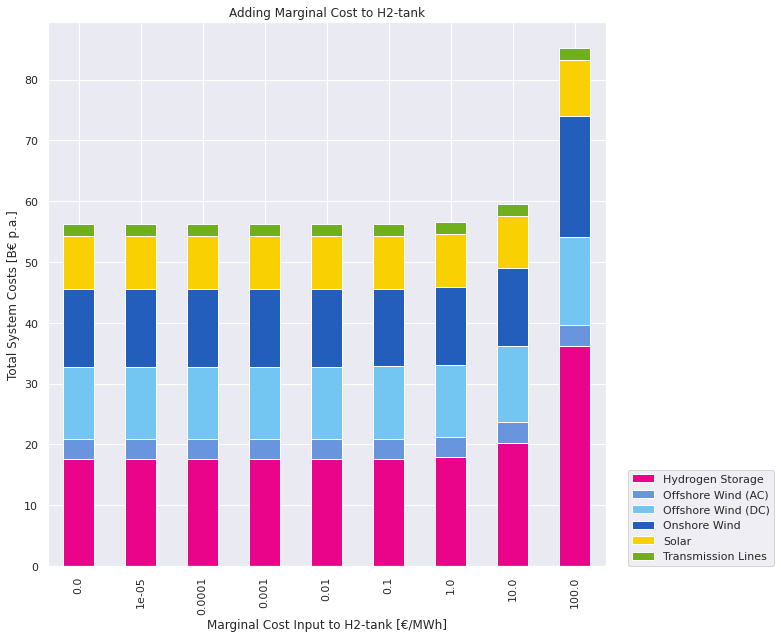

In [50]:
costs.iloc[:,20:29].T.plot.bar(stacked=True, figsize=(10,10),color = color)
plt.legend(loc=(1.04,0))
plt.title("Adding Marginal Cost to H2-tank")
plt.xlabel("Marginal Cost Input to H2-tank [€/MWh]")
plt.ylabel("Total System Costs [B€ p.a.]")

Text(0, 0.5, 'Total System Costs [B€ p.a.]')

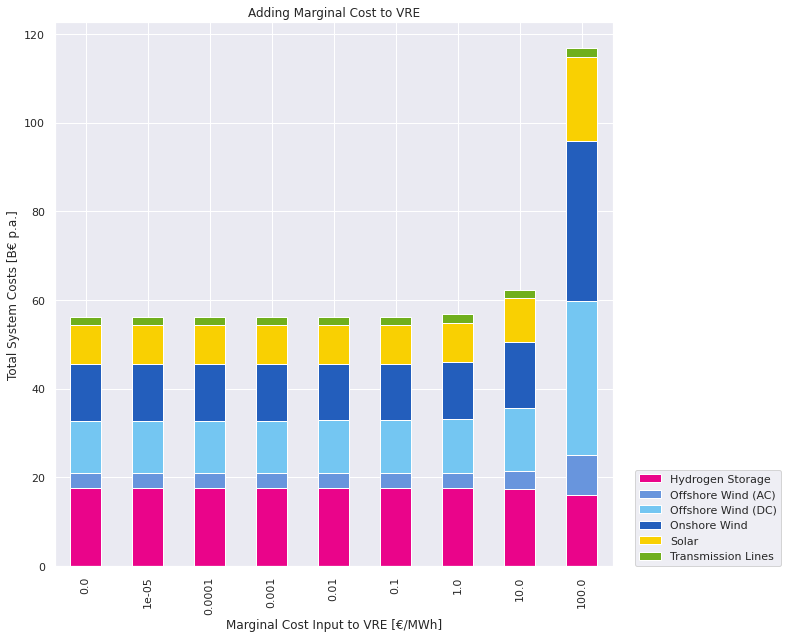

In [51]:
costs.iloc[:,30:39].T.plot.bar(stacked=True, figsize=(10,10),color = color)
plt.legend(loc=(1.04,0))
plt.title("Adding Marginal Cost to VRE")
plt.xlabel("Marginal Cost Input to VRE [€/MWh]")
plt.ylabel("Total System Costs [B€ p.a.]")

In [52]:
###CHECK
values = list(ns.values())
keys = list(ns.keys())
objective =  []

for i in range(0, len(keys)):
    C = calculate_objective(values[i], keys[i])
    objective.append(C)

In [53]:
objective

[('n10', 54.624651313464334),
 ('n11', 54.624909865308766),
 ('n12', 54.62543843285082),
 ('n13', 54.624286184510105),
 ('n14', 54.62634981923347),
 ('n15', 54.64360340939186),
 ('n16', 54.811428602770974),
 ('n17', 56.494570576786586),
 ('n18', 72.05626215718841),
 ('n19', 145.95186630784625),
 ('n20', 54.62459868767307),
 ('n21', 54.62478969214869),
 ('n22', 54.62501830565556),
 ('n23', 54.625257701753966),
 ('n24', 54.6262764972781),
 ('n25', 54.64037093623595),
 ('n26', 54.775451424363595),
 ('n27', 56.120815810148066),
 ('n28', 68.77763584933369),
 ('n29', 133.4823919716309),
 ('n30', 54.62437860941643),
 ('n31', 54.624762798864175),
 ('n32', 54.625147654336374),
 ('n33', 54.624265494652704),
 ('n34', 54.62798093388382),
 ('n35', 54.65842787986741),
 ('n36', 54.962041222227995),
 ('n37', 57.96343729959124),
 ('n38', 83.61986177161076),
 ('n39', 189.92803283023005),
 ('n40', 54.624651313464334),
 ('n41', 54.62554173437007),
 ('n42', 54.623492200629386),
 ('n43', 54.62485077186844),

# FLH/capacity factor generator

In [54]:
cd "/home/max/OneDrive/PHD-Flexibility/08_2_SecondPaper/unintended-storage-cycling/Model_scripts"

/home/max/OneDrive/PHD-Flexibility/08_2_SecondPaper/unintended-storage-cycling/Model_scripts


In [55]:
import sys, os
import yaml

with open("config.yaml", 'r') as stream:
    config = yaml.safe_load(stream)

In [56]:
def aggregate_p(n):
    return pd.concat([
        n.generators_t.p.sum().groupby(n.generators.carrier).sum(),
        n.storage_units_t.p.sum().groupby(n.storage_units.carrier).sum(),
        n.stores_t.p.sum().groupby(n.stores.carrier).sum(),
        n.links.groupby("carrier").p_nom_opt.sum(),
        -n.loads_t.p.sum().groupby(n.loads.carrier).sum()
        ])

In [57]:
#def aggregate_costs(n, flatten=False, opts=None, existing_only=False):
for key, n in ns.items():
    assign_carriers(n)
    
costs = pd.DataFrame({k: aggregate_p_curtailed(n)/(aggregate_p_nom(n)*8760) for k, n in ns.items()}).sort_index(axis=1)#.drop("load")
#colors = costs.index.map(config["plotting"]["tech_colors"])
#colors = (config["plotting"]["tech_colors"])
costs = costs.rename(index=config["plotting"]["nice_names"])

costs = costs #Conversion to billions
#costs[:]

In [58]:
#costs
#Percentage of curtailment

Text(0, 0.5, 'Average VRE p_curtailed/p_nom')

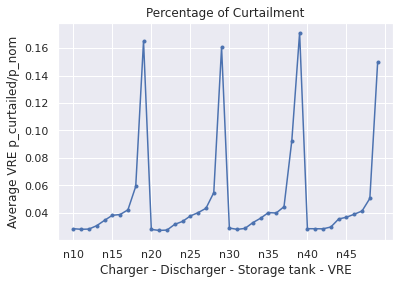

In [59]:
((
    costs.loc["Solar"]
    +costs.loc["Onshore Wind"]
    +costs.loc["Offshore Wind (AC)"]
    +costs.loc["Offshore Wind (DC)"]
    #+costs.loc["Run of River"]
    #costs.loc["hydro+PHS"]
    
)/5).plot(style='.-')

plt.title("Percentage of Curtailment")
plt.xlabel("Charger - Discharger - Storage tank - VRE")
plt.ylabel("Average VRE p_curtailed/p_nom")

In [60]:
#def aggregate_costs(n, flatten=False, opts=None, existing_only=False):
for key, n in ns.items():
    assign_carriers(n)
    
costs = pd.DataFrame({k: aggregate_p(n)/(aggregate_p_nom(n)*8760) for k, n in ns.items()}).sort_index(axis=1)#.drop("load")
#colors = costs.index.map(config["plotting"]["tech_colors"])
#colors = (config["plotting"]["tech_colors"])
costs = costs.rename(index=config["plotting"]["nice_names"])

costs = costs #Conversion to billions
#costs[:]

Text(0, 0.5, 'p/(p_nom*8760)')

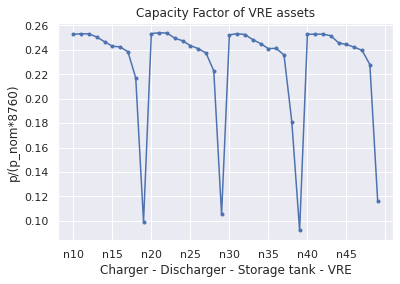

In [61]:
((
    costs.loc["Solar"]
    +costs.loc["Onshore Wind"]
    +costs.loc["Offshore Wind (AC)"]
    +costs.loc["Offshore Wind (DC)"]
    #+costs.loc["Run of River"]
    #costs.loc["hydro+PHS"]
    
)/5).plot(style='.-')

plt.title("Capacity Factor of VRE assets")
plt.xlabel("Charger - Discharger - Storage tank - VRE")
plt.ylabel("p/(p_nom*8760)")

In [62]:
#def aggregate_costs(n, flatten=False, opts=None, existing_only=False):
for key, n in ns.items():
    assign_carriers(n)
    
costs = pd.DataFrame({k: aggregate_p(n)/(aggregate_p_nom(n)) for k, n in ns.items()}).sort_index(axis=1)#.drop("load")
#colors = costs.index.map(config["plotting"]["tech_colors"])
#colors = (config["plotting"]["tech_colors"])
costs = costs.rename(index=config["plotting"]["nice_names"])

costs = costs #Conversion to billions
#costs[:]

In [63]:
costs
#FLH of generators

,n10,n11,n12,n13,n14,n15,n16,n17,n18,n19,...,n40,n41,n42,n43,n44,n45,n46,n47,n48,n49
carrier,,,,,,,,,,,,,,,,,,,,,
Hydrogen Storage,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
H2 electrolysis,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
H2 fuel cell,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
electricity,-8760.000000,-8760.000000,-8760.000000,-8760.000000,-8760.000000,-8760.000000,-8760.000000,-8760.000000,-8760.000000,-8760.000000,...,-8760.000000,-8760.000000,-8760.000000,-8760.000000,-8760.000000,-8760.000000,-8760.000000,-8760.000000,-8760.000000,-8760.000000
Transmission Lines,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
Offshore Wind (AC),3745.593611,3767.994999,3767.932240,3768.850770,3708.074336,3645.293829,3659.336669,3537.428599,3267.546168,1764.559491,...,3745.593611,3746.460190,3786.964817,3783.906855,3659.624773,3684.026562,3641.588456,3553.484285,3459.899285,1974.947577
Offshore Wind (DC),4527.937545,4520.905969,4511.208474,4438.716687,4379.745385,4312.433301,4285.022422,4269.423076,3989.317411,1485.170770,...,4527.937545,4530.096846,4499.509032,4462.560896,4374.325094,4325.449278,4288.557665,4275.260755,4069.344680,1786.840245
Onshore Wind,2036.734094,2039.201567,2042.089137,2012.103814,1965.946281,1940.450604,1929.468339,1894.594082,1551.020477,673.307797,...,2036.734094,2034.790397,2032.566334,2011.933317,1975.547065,1951.470641,1938.466752,1918.696105,1734.060224,855.812654
Solar,756.619795,757.680708,757.652560,751.514858,747.525252,742.184699,740.260693,739.856731,699.237290,423.843793,...,756.619795,756.599051,752.679734,754.803984,748.922927,739.882918,737.108142,743.104869,720.362735,489.187029


Text(0, 0.5, 'Average p/pnom [h]')

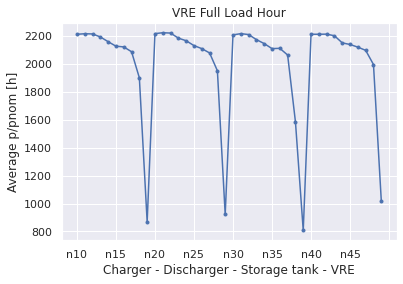

In [64]:
((
    costs.loc["Solar"]
    +costs.loc["Onshore Wind"]
    +costs.loc["Offshore Wind (AC)"]
    +costs.loc["Offshore Wind (DC)"]
    #+costs.loc["Run of River"]
    #+costs.loc["hydro+PHS"]
    
)/5).plot(style='.-')

plt.title("VRE Full Load Hour")
plt.xlabel("Charger - Discharger - Storage tank - VRE")
plt.ylabel("Average p/pnom [h]")

In [65]:
#def aggregate_costs(n, flatten=False, opts=None, existing_only=False):
for key, n in ns.items():
    assign_carriers(n)
    
costs = pd.DataFrame({k: aggregate_p_nom(n) for k, n in ns.items()}).sort_index(axis=1)#.drop("load")
#colors = costs.index.map(config["plotting"]["tech_colors"])
#colors = (config["plotting"]["tech_colors"])
costs = costs.rename(index=config["plotting"]["nice_names"])

costs = costs #Conversion to billions
#costs[:]

In [66]:
#optimised capacity
costs.sum()

n10    5.910965e+05
n11    5.911065e+05
n12    5.910865e+05
n13    5.910913e+05
n14    5.910555e+05
n15    5.910153e+05
n16    5.908879e+05
n17    5.880248e+05
n18    5.884601e+05
n19    9.863609e+05
n20    5.910707e+05
n21    5.911041e+05
n22    5.910893e+05
n23    5.911046e+05
n24    5.910706e+05
n25    5.910688e+05
n26    5.909620e+05
n27    5.884525e+05
n28    5.865934e+05
n29    9.322609e+05
n30    5.910767e+05
n31    5.910970e+05
n32    5.910827e+05
n33    5.910263e+05
n34    5.910440e+05
n35    5.909978e+05
n36    5.909835e+05
n37    5.866311e+05
n38    6.444037e+05
n39    1.087988e+06
n40    5.910965e+05
n41    5.911080e+05
n42    5.910242e+05
n43    5.910266e+05
n44    5.910089e+05
n45    5.910497e+05
n46    5.908902e+05
n47    5.893423e+05
n48    5.850350e+05
n49    8.614962e+05
dtype: float64

Text(0, 0.5, 'p_nom in [MW]')

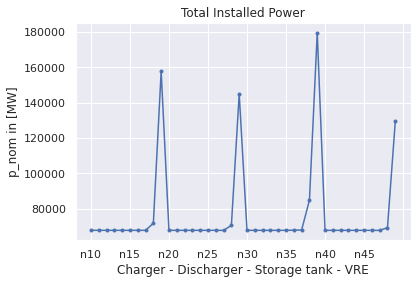

In [67]:
((
    costs.loc["Solar"]
    +costs.loc["Onshore Wind"]
    +costs.loc["Offshore Wind (AC)"]
    +costs.loc["Offshore Wind (DC)"]
    #+costs.loc["Run of River"]
    #+costs.loc["hydro+PHS"]
    
)/5).plot(style='.-')

plt.title("Total Installed Power")
plt.xlabel("Charger - Discharger - Storage tank - VRE")
plt.ylabel("p_nom in [MW]")

In [68]:
#def aggregate_costs(n, flatten=False, opts=None, existing_only=False):
for key, n in ns.items():
    assign_carriers(n)
    
costs = pd.DataFrame({k: aggregate_p(n) for k, n in ns.items()}).sort_index(axis=1)#.drop("load")
#colors = costs.index.map(config["plotting"]["tech_colors"])
#colors = (config["plotting"]["tech_colors"])
costs = costs.rename(index=config["plotting"]["nice_names"])

costs = costs #Conversion to billions
#costs[:]

In [69]:
#power output
costs

,n10,n11,n12,n13,n14,n15,n16,n17,n18,n19,...,n40,n41,n42,n43,n44,n45,n46,n47,n48,n49
carrier,,,,,,,,,,,,,,,,,,,,,
Offshore Wind (AC),6.155023e+07,6.192069e+07,6.191910e+07,6.192516e+07,6.092851e+07,5.989204e+07,6.010169e+07,5.812347e+07,5.455765e+07,3.971951e+07,...,6.155023e+07,6.157608e+07,6.221216e+07,6.217073e+07,6.012270e+07,6.054512e+07,5.981062e+07,5.836662e+07,5.690968e+07,4.337211e+07
Offshore Wind (DC),2.192063e+08,2.188259e+08,2.184483e+08,2.148859e+08,2.121410e+08,2.089649e+08,2.078738e+08,2.141043e+08,2.147534e+08,9.967773e+07,...,2.192063e+08,2.192830e+08,2.180045e+08,2.162224e+08,2.119802e+08,2.095136e+08,2.081356e+08,2.112704e+08,2.153189e+08,1.199205e+08
Onshore Wind,2.378107e+08,2.381333e+08,2.383897e+08,2.349336e+08,2.294185e+08,2.264561e+08,2.253174e+08,2.204266e+08,2.260975e+08,2.843446e+08,...,2.378107e+08,2.376171e+08,2.371305e+08,2.347115e+08,2.304377e+08,2.277796e+08,2.260694e+08,2.227410e+08,2.215571e+08,2.653618e+08
Solar,1.194533e+08,1.196228e+08,1.196152e+08,1.186498e+08,1.180260e+08,1.171649e+08,1.168453e+08,1.158181e+08,1.001125e+08,1.169466e+08,...,1.194533e+08,1.194451e+08,1.188423e+08,1.191769e+08,1.182493e+08,1.167948e+08,1.163536e+08,1.168932e+08,1.080689e+08,1.212053e+08
Hydrogen Storage,8.485586e-10,-7.839844e-10,1.426088e-09,-6.248229e-10,-8.349161e-10,8.358256e-10,-3.703917e-10,-1.270564e-09,-6.002665e-10,4.329195e-10,...,8.485586e-10,-1.466105e-09,4.010872e-10,-4.010872e-10,-1.333319e-09,9.167707e-10,-3.713012e-10,-5.579750e-10,4.365575e-10,-3.274181e-10
H2 electrolysis,7.422042e+04,7.422168e+04,7.422107e+04,7.421792e+04,7.421408e+04,7.417603e+04,7.397798e+04,7.135526e+04,5.443755e+04,3.740593e+04,...,7.422042e+04,7.422340e+04,7.420389e+04,7.420849e+04,7.420030e+04,7.420955e+04,7.408457e+04,7.281832e+04,6.160395e+04,4.732515e+04
H2 fuel cell,1.192597e+05,1.192575e+05,1.192577e+05,1.192600e+05,1.192569e+05,1.192544e+05,1.192294e+05,1.190699e+05,1.164086e+05,1.029739e+05,...,1.192597e+05,1.192573e+05,1.192563e+05,1.192543e+05,1.192533e+05,1.192572e+05,1.192500e+05,1.191629e+05,1.181309e+05,1.090750e+05
Transmission Lines,1.013177e+01,9.743287e+00,1.373431e+01,6.717119e+00,8.004131e+00,7.644067e+00,1.017760e+00,1.086407e+01,1.455572e+01,3.975949e+00,...,1.013177e+01,1.419712e+01,4.323127e+00,7.053616e+00,5.957270e+00,1.009380e+01,1.191922e+00,2.166909e+00,2.812784e+01,5.986456e+01
electricity,-5.091589e+08,-5.091589e+08,-5.091589e+08,-5.091589e+08,-5.091589e+08,-5.091589e+08,-5.091589e+08,-5.091589e+08,-5.091589e+08,-5.091589e+08,...,-5.091589e+08,-5.091589e+08,-5.091589e+08,-5.091589e+08,-5.091589e+08,-5.091589e+08,-5.091589e+08,-5.091589e+08,-5.091589e+08,-5.091589e+08


Text(0, 0.5, 'p in [MW]')

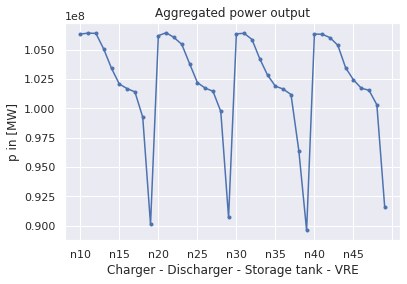

In [70]:
((
    costs.loc["Solar"]
    +costs.loc["Onshore Wind"]
    +costs.loc["Offshore Wind (AC)"]
    +costs.loc["Offshore Wind (DC)"]
    #+costs.loc["Run of River"]
    #+costs.loc["hydro+PHS"]
    
)/6).plot(style='.-')

plt.title("Aggregated power output")
plt.xlabel("Charger - Discharger - Storage tank - VRE")
plt.ylabel("p in [MW]")